<table width="100%" style="padding:0; margin-left:-6px;">
    <tr style="padding=0;" width="100%">
        <td width="auto">
           <hr style="border:2px solid darkblue">
            <h1> nb4. Query by scientific category</h1>
           <hr style="border:2px solid darkblue">
        </td>
        <td width="60px">
           <img src="ALMAsmall.png" align="right"/> 
        </td>
    </tr>
</table>    

The relevant columns in the ALMA TAP service are:
* *science_category* 
* *science_keyword*
 
--------- ----- -----

The scientific categories of observations are:
* Active galaxies
* Cosmology
* Disks and planet formation
* Galaxy evolution
* ISM and star formation
* Local Universe
* Solar system
* Stars and stellar evolution
* Sun

Note: these categories are stable in time and valid for all ALMA Cycles and may thus slighly differ from the categories in the ALMA Observing Tool which can change from Cycle to Cycle.



In [1]:
import numpy as np
from astropy.table import Table
import pyvo
import sys
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.cluster

service = pyvo.dal.TAPService("https://almascience.eso.org/tap")      # for the EU ALMA TAP service

# service = pyvo.dal.TAPService("https://almascience.nao.ac.jp/tap")  # for the EA ALMA TAP service
# service = pyvo.dal.TAPService("https://almascience.nrao.edu/tap")   # for the NA ALMA TAP service

<hr style="border:2px solid darkblue"> </hr>


## Query scientific category
<hr style="border:2px solid darkblue"> </hr>



In [2]:
def query_scientific_category(service, scientific_category):
    """Query for all science observations of a given scientific category. To reduce the memory
       requirements, rather than using *, it is often useful to select the columns of interest.
    
       service               pyvo TAPService instance
       scientific_category   one of the categories shown at the top of this notebook
       
       returns               pandas table    
    """
    
    query = f"""  
            SELECT target_name, science_keyword, s_ra, s_dec, band_list
            FROM ivoa.obscore  
            WHERE scientific_category = '{scientific_category}'  
            AND science_observation = 'T'  
            GROUP BY target_name, science_keyword, s_ra, s_dec, band_list
            """

    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>


## Query science keyword and data type
<hr style="border:2px solid darkblue"> </hr>




In [3]:
def query_science_keyword(service, science_keyword):
    """ALMA has a long list of scientific keywords in the Observing Tool from whch PIs need to select
       one or two in their proposals. This query returns all science observations for a given science 
       keyword (or part of it).
       
       service               pyvo TAPService instance
       science_keyword       one of the science keywords of ALMA or a substring
       
       returns               pandas table       
       """
    
    query = f"""  
            SELECT s_ra, s_dec, target_name, band_list, t_exptime
            FROM ivoa.obscore  
            WHERE science_observation = 'T'  
            AND science_keyword like '%{science_keyword}%'  
            GROUP BY s_ra, s_dec, target_name, band_list, t_exptime
            """
    
    return service.search(query).to_table().to_pandas()

In [4]:
def query_science_keyword_datatype(service, science_keyword, datatype):
    """This function shows how to combine several constraints. Here the science keyword as well 
       as the datatype and science_observations
    
       service               pyvo TAPService instance
       science_keyword       one of the science keywords of ALMA or a substring
       datatype              "image" or "cube"
       
       returns               pandas table    
    """
    
    query = f"""   
            SELECT s_ra, s_dec, target_name, band_list, t_exptime
            FROM ivoa.obscore  
            WHERE science_keyword like '%{science_keyword}%'  
            AND science_observation = 'T'  
            AND dataproduct_type = '{datatype}'   
            GROUP BY s_ra, s_dec, target_name, band_list, t_exptime
            """
    
    return service.search(query).to_table().to_pandas()

-------------------------------------------------

## Example 4a: How many active galaxies (science category) have been observed with ALMA? 
These queries only return science observations, not calibrator observations.

In [5]:
output_agn = query_scientific_category(service, 'Active galaxies')

In [6]:
print(f"There are {len(np.unique(output_agn['target_name']))} unique target names within the list of {len(output_agn)} results.")

There are 9865 unique target names within the list of 12844 results.


Showing the first 30 unique target names:

In [7]:
np.set_printoptions(threshold=sys.maxsize)
np.array(np.unique(output_agn['target_name']))[0:30]

array(['0-10000', '0-10510', '0-12043', '0-12407', '0-13299', '0-13375',
       '0-1426', '0-1437', '0-16822', '0-17244', '0-17749', '0-18038',
       '0-18180', '0-19883', '0-22825', '0-2318', '0-23382', '0-23626',
       '0-24625', '0-24636', '0-26339', '0-34302', '0-34622', '0-34897',
       '0-3662', '0-3753', '0-3973', '0-4356', '0-4503', '0-4936'],
      dtype=object)

In which bands have the AGN (as determined by the science category) been observed?

<AxesSubplot:>

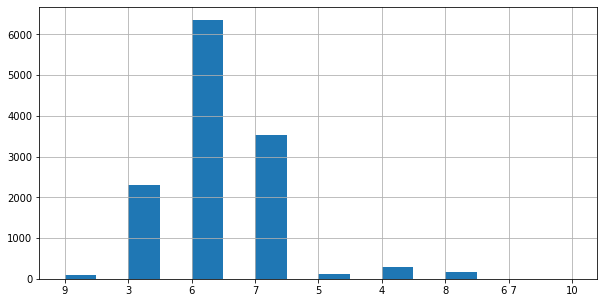

In [8]:
plt.rcParams["figure.figsize"] = (10,5)
output_agn['band_list'].hist(bins = 16)

Where have they been observed?

Text(0, 0.5, 'Dec')

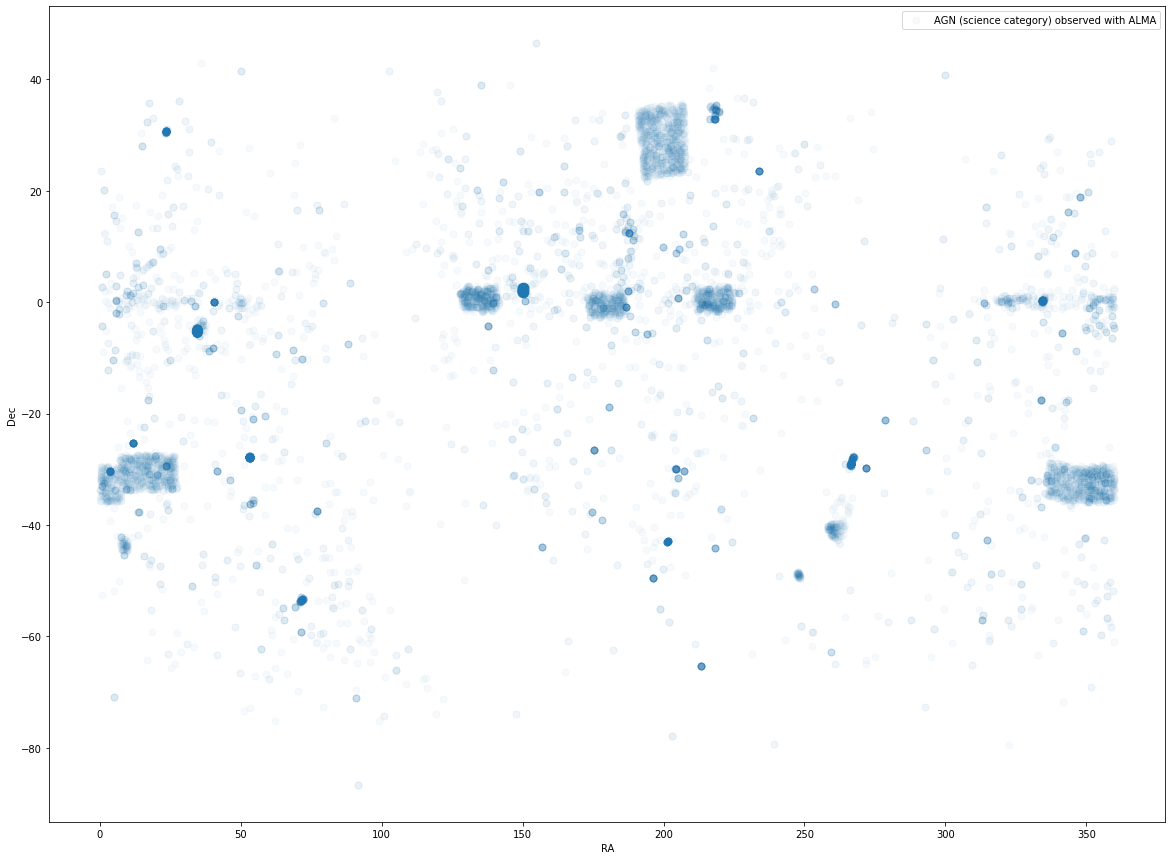

In [9]:
plt.rcParams["figure.figsize"] = (20,15)
output_agn.plot(x='s_ra',y='s_dec', linestyle='', ms=7, marker='o', alpha=0.03, label='AGN (science category) observed with ALMA')
plt.xlabel('RA')
plt.ylabel('Dec')

Within this science category there are several combinations of science keywords. We split each combination of science keywords up and then plot the pie chart.

Starburst galaxies                                                   7643
Sub-mm Galaxies (SMG)                                                5877
Active Galactic Nuclei (AGN)/Quasars (QSO)                           1993
Starbursts                                                           1707
star formation                                                       1707
Galaxy structure & evolution                                         1368
High-z Active Galactic Nuclei (AGN)                                   993
feedback                                                              961
Outflows                                                              961
jets                                                                  961
Galactic centres/nuclei                                               852
Surveys of galaxies                                                   349
Luminous and Ultra-Luminous Infra-Red Galaxies (LIRG & ULIRG)         321
Giant Molecular Clouds (GMC) propertie

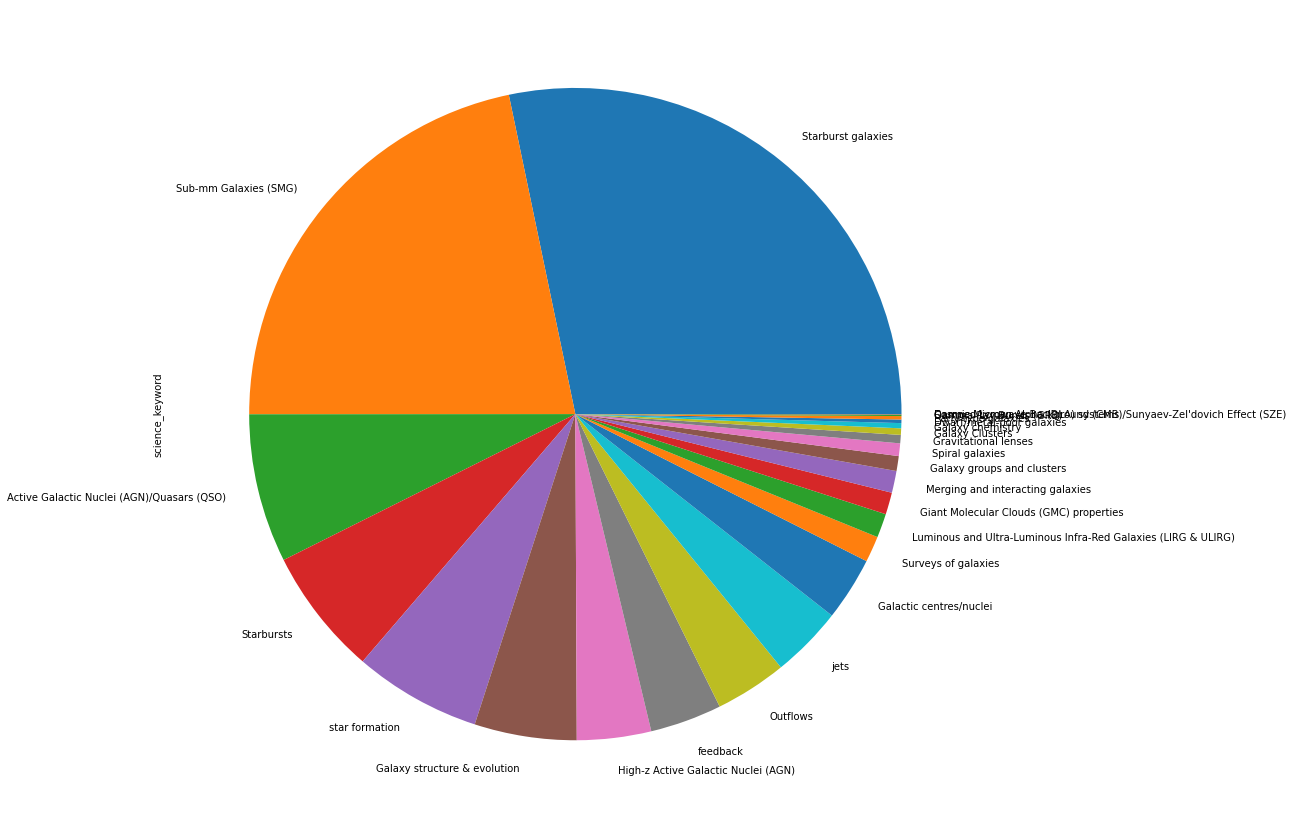

In [10]:
flattened_science_keywords = [item.strip() for sublist in [keyword.split(',') for keyword in output_agn['science_keyword']] for item in sublist]
pd.DataFrame({'science_keyword':flattened_science_keywords})['science_keyword'].value_counts().plot.pie()
pd.DataFrame({'science_keyword':flattened_science_keywords})['science_keyword'].value_counts()

Show the list of all Science Keywords in the the ALMA database:

In [11]:
query = f"""SELECT DISTINCT(science_keyword) from ivoa.obscore"""
flattened_science_keywords = sorted(list(set([item.strip() for sublist in [keyword.split(',') for keyword in service.search(query).to_table().to_pandas()['(science_keyword)']] for item in sublist])))
print(*flattened_science_keywords, sep="\n")


Active Galactic Nuclei (AGN)/Quasars (QSO)
Astrochemistry
Asymptotic Giant Branch (AGB) stars
Black holes
Brown dwarfs
Cataclysmic stars
Cosmic Microwave Background (CMB)/Sunyaev-Zel'dovich Effect (SZE)
Damped Lyman Alpha (DLA) systems
Debris disks
Disks around high-mass stars
Disks around low-mass stars
Dwarf/metal-poor galaxies
Early-type galaxies
Evolved stars - Chemistry
Evolved stars - Shaping/physical structure
Evolved stars: Shaping/physical structure
Exo-planets
Exoplanets
Galactic centres/nuclei
Galaxy Clusters
Galaxy chemistry
Galaxy groups and clusters
Galaxy structure & evolution
Galaxy structure &evolution
Gamma Ray Bursts (GRB)
Giant Molecular Clouds (GMC) properties
Gravitational lenses
HII regions
High-mass star formation
High-z Active Galactic Nuclei (AGN)
Hypergiants
Infra-Red Dark Clouds (IRDC)
Inter-Stellar Medium (ISM)/Molecular clouds
Intermediate-mass star formation
Low-mass star formation
Luminous Blue Variables (LBV)
Luminous and Ultra-Luminous Infra-Red Galax

----------------------------

## Example 4b : How many sub-mm galaxies (science keyword) have been observed?

First, we investigate this question using the corresponding scientific keyword.

In [12]:
output_smgs_scikey = query_science_keyword(service, 'Sub-mm Galaxies (SMG)')
print(f"There are {len(output_smgs_scikey)} observations with keyword 'Sub-mm Galaxies (SMG)'.")

There are 10649 observations with keyword 'Sub-mm Galaxies (SMG)'.


Similarly, we can look for sub-millimeter Galaxies in the proposal abstract texts. For example with 

In [13]:
query = """
        SELECT s_ra, s_dec, target_name, t_exptime
        FROM ivoa.obscore
        WHERE proposal_abstract like '%SMG%'
        OR proposal_abstract like '%ub-mm galax%'
        AND science_observation = 'T'
        GROUP BY s_ra, s_dec, target_name, t_exptime
        """           

output_smgs_abstract = service.search(query).to_table().to_pandas()

In [14]:
print(f"There are {len(output_smgs_abstract)} observations where the proposal abstract mentions strings related to SMGs.")

There are 6035 observations where the proposal abstract mentions strings related to SMGs.


We can now plot the position of these sub-mm galaxies observations:

<AxesSubplot:xlabel='s_ra'>

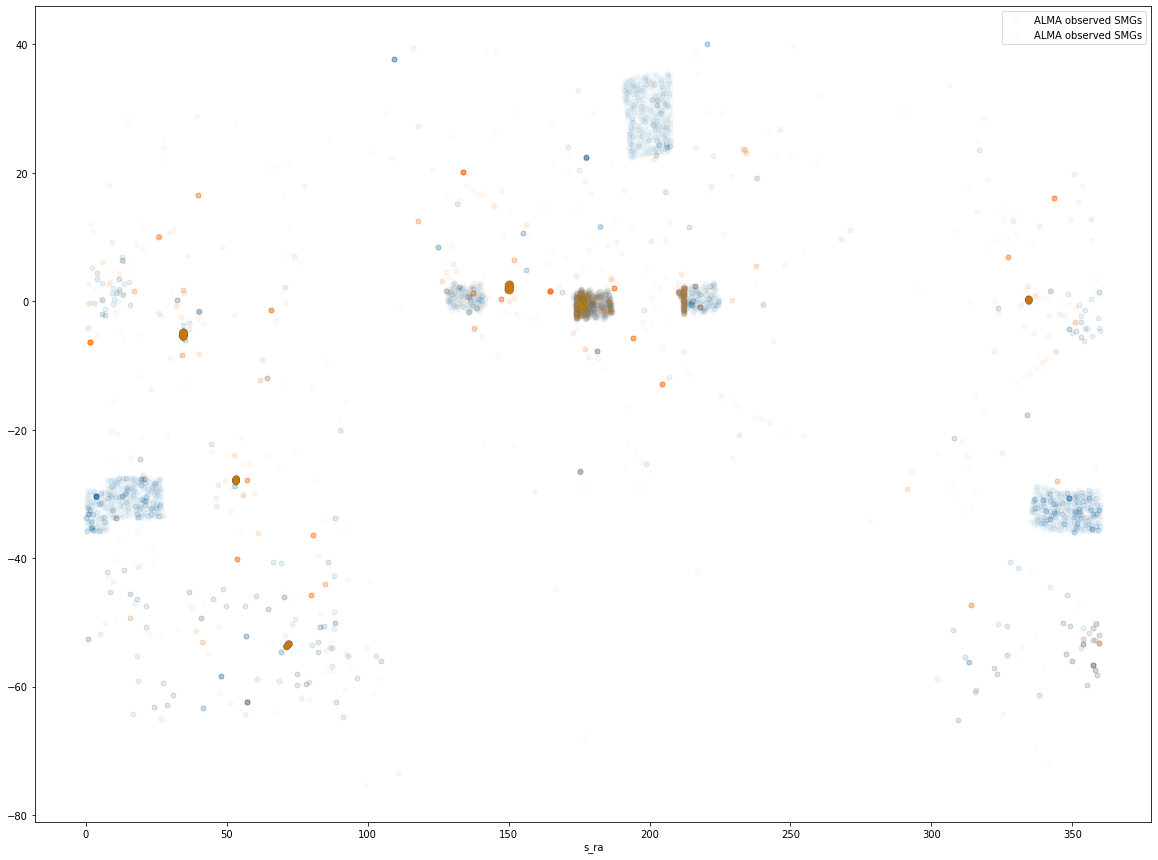

In [15]:
plt.rcParams["figure.figsize"] = (20,15)
ax = output_smgs_scikey.plot(x='s_ra',y='s_dec', linestyle='', ms=5, marker='o', label='ALMA observed SMGs', alpha=0.02)
output_smgs_abstract.plot(x='s_ra',y='s_dec', linestyle='', ms=5, marker='o', label='ALMA observed SMGs', alpha=0.02, ax=ax)

----------------------------

## Example 4c : Which sub-mm galaxies have been observed the longest with ALMA?



To answer this question, we first group the observations together:

In [16]:
# link recursively all observations together where the centre distance of any observation pair is less than 30 arcsec. 
eps = 30/60/60*3.1415927/180
cluster = sklearn.cluster.DBSCAN(eps=eps, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(output_smgs_scikey[['s_ra', 's_dec']].to_numpy()))
output_smgs_scikey['galaxylabels'] = cluster.labels_

We then sum the exposure times, sort by them and print out a summary of the groups of observations identified. The entry 0 of that list contains all the observations that have no overlap with other observations and that group thus has to be skipped.

In [17]:
output_clustered_and_sorted = output_smgs_scikey.groupby(['galaxylabels'])['t_exptime'].agg('sum').reset_index().sort_values('t_exptime', ascending=False)

plotarray = []
for i, row in output_clustered_and_sorted.iloc[1:51].iterrows():
    galaxylabel = int(row['galaxylabels'])    
    galaxygroup = output_smgs_scikey.loc[(output_smgs_scikey['galaxylabels']==galaxylabel)]
    plotarray.append([row['t_exptime']/3600, galaxygroup['target_name'].values[0]])
    print(f"Group number {galaxylabel} with ")
    print(f"    - {len(galaxygroup['s_ra'])} observations \n    - total exposure time {row['t_exptime']/3600:.1f} hours")
    print(f"    - average ra={galaxygroup['s_ra'].mean():.4f} and dec={galaxygroup['s_dec'].mean():.4f} ")
    print(f"    - has the unique source names: {', '.join(list(set(galaxygroup['target_name'].values)))}\n")

Group number 548 with 
    - 8 observations 
    - total exposure time 21.5 hours
    - average ra=135.7983 and dec=0.6518 
    - has the unique source names: SDP81, SDP_81, SDP.81, ID81

Group number 0 with 
    - 13 observations 
    - total exposure time 19.1 hours
    - average ra=181.3462 and dec=-7.7088 
    - has the unique source names: BR1202, BR1202-0725

Group number 90 with 
    - 16 observations 
    - total exposure time 18.5 hours
    - average ra=47.8863 and dec=-58.3924 
    - has the unique source names: SPT0311-58

Group number 469 with 
    - 14 observations 
    - total exposure time 16.4 hours
    - average ra=149.9286 and dec=2.4940 
    - has the unique source names: AS2COS0023.1, AzTEC-1, AzTEC1, AzTECC5, COS850.0023, S2COSMOS.850.6

Group number 289 with 
    - 13 observations 
    - total exposure time 16.1 hours
    - average ra=149.9949 and dec=2.5805 
    - has the unique source names: AzTEC_8, AzTECC2a, AzTECC2b, S2COS.0328, AS2COS0028.1, AzTEC8, AzTECC2


We now plot the 50 SMGs with the longest total exposure times:

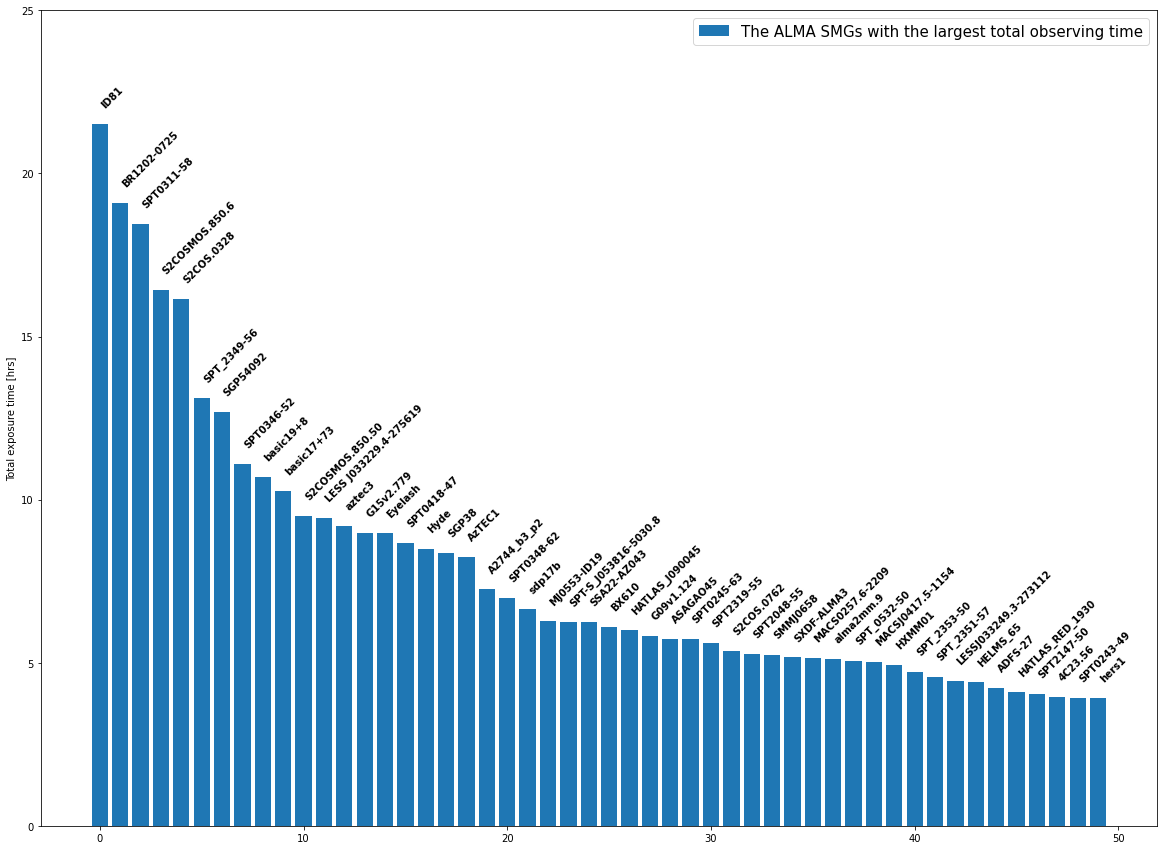

In [18]:
plt.bar(np.arange(len(plotarray)),np.array([p[0] for p in plotarray]), align='center', label='The ALMA SMGs with the largest total observing time')

for i in range(len(plotarray)):
    plt.text(i, plotarray[i][0]+0.5 , plotarray[i][1], color='black', fontweight='bold', rotation=45 )

plt.ylim(0,25)
plt.ylabel('Total exposure time [hrs]')
plt.legend(fontsize=15)

----------------------------------------------

## Example 4d : How many quasars have been observed with ALMA?

In [19]:
output_qsos_cube = query_science_keyword_datatype(service, 'Quasars', 'cube' )
output_qsos_image = query_science_keyword_datatype(service, 'Quasars', 'image' )
print(f"There are {len(np.unique(output_qsos_cube['target_name']))} line observations (cube) and {len(np.unique(output_qsos_image['target_name']))} continuum observations (line) in the ALMA database.")

There are 681 line observations (cube) and 865 continuum observations (line) in the ALMA database.
